In [1]:
import numpy as np 
import os
import pandas as pd 
import datetime
import drms
import urllib
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import urllib, requests
import matplotlib.pyplot as plt
from sunpy.coordinates import frames
import warnings
warnings.filterwarnings("ignore")
import sunpy.wcs
import sunpy.map
import pickle
import re
import matplotlib.patches as patches
%matplotlib inline

##  На заданную дату отмечаем все области на магнитограмме

In [2]:
EMAIL = 'iknyazeva@gmail.com'
SAVE_PATH = 'dataset'

def check_dataset_directory():
    if not os.path.exists('dataset/fragments'):
        logging.warning('dataset folders not exist, create them')
        os.makedirs('dataset/fragments')
    
    return 'dataset'

## Sunspots data:

aggregated from   https://www.spaceweatherlive.com, which in turn aggregated from
ftp://ftp.swpc.noaa.gov/pub/warehouse/, location valid at 0 a.m

In [3]:
sunspots = pickle.load(urllib.request.urlopen('https://raw.githubusercontent.com/iknyazeva/FitsProcessing/master/sunspot_1996_2017.pkl'))
sunspots.tail(5)

,,number_of_ss,size,class,location,magn_class
date,region,,,,,
2017-12-24,12692,12,90,DAO,N18E03,B
2017-12-25,12692,12,160,EAI,N18W09,B
2017-12-26,12692,7,100,EAO,N18W23,B
2017-12-27,12692,4,30,CRO,N18W35,B
2017-12-28,12692,1,10,AXX,N17W46,A


In [5]:
dr = sunspots.loc['2011-04-11']
dr.index = dr.index.droplevel()
dr

,number_of_ss,size,class,location,magn_class
region,,,,,
11185,15,60,DSI,N17W08,B
11186,8,70,DSO,N23E06,B
11187,3,20,BXO,S18E23,B


In [7]:
def request_mfits_by_date(moment, email = EMAIL, path_to_sace = 'dataset'):
    """
    Function for request fits from JSOC database
    moment: pd.datetime object
    return: filepath to the magnetogram
    """

    c = drms.Client(email=email, verbose=True)
    str_for_query = 'hmi.m_720s'+ moment.strftime('[%Y.%m.%d_%H:%M:%S_TAI]{magnetogram}')
    print('Magnetogram:',str_for_query, ' will be downloaded .. ')
    r = c.export(str_for_query, method='url', protocol='fits')
    print(r)
    r.wait()
    print(r.request_url)
    filename ='hmi.m_720s.' +  moment.strftime('%Y%m%d_%H%M%S_TAI.magnetogram.fits')
    filepath = os.path.join('dataset', filename)

    print("Download data and save to path", filepath)
    r.download('dataset') 
    return filepath

def read_fits_to_map(filepath, plot_show=True):
    """
    read fits to sunpy object and plot in logariphmic scale
    return 
    mymap: sunpy object
    
    """
    
    mymap = sunpy.map.Map(filepath)
    if plot_show:
        plt.figure(figsize = (12,12))

        data = np.sign(mymap.data)*np.log1p(np.abs(mymap.data))
        plt.imshow(data, cmap = 'gray' )
    
    return mymap

def region_coord_list(datestr, sunspots_df=sunspots, limit_deg=45):
    """
    Function for working with sunspot_1996_2017.pkl dataframe, 
    which located here https://raw.githubusercontent.com/iknyazeva/FitsProcessing/master/sunspot_1996_2017.pkl,
    return list of tuples: (datestr, NOAA number, location)
    used in cropping
    
    args:
    datestr: string for date in the format used in dataframe '2001-04-30'
    sunspots_df: dataframe from file sunspot_1996_2017.pkl
    
    return: list of tuples
    """
    date_df = sunspots.loc[datestr]
    date_df.index = date_df.index.droplevel()
    rc_list = []
    for index, row in date_df.iterrows():
        if (abs(float(row.location[1:3])<=limit_deg)) and (abs(float(row.location[4:]))<=limit_deg):
            rc_list.append((pd.to_datetime(datestr, format='%Y-%m-%d'), index, row.location))
    return rc_list

def return_pixel_from_map(mag_map, record):
    pattern = re.compile("[NS]\d{2}[EW]\d{2}")
    assert bool(pattern.match(record)), 'Pattern should be in the same format as N20E18'
    assert (abs(float(record[1:3])<=45)) and (abs(float(record[4:]))), 'Consider only regions between -45, +45 degree'
    if record[0]=='N':
        lat = float(record[1:3])
    else:
        lat = -float(record[1:3])
    if record[3]=='W':
        lon = float(record[4:])
    else:
        lon = -float(record[4:])
        
    hpc_coord = sunpy.wcs.convert_hg_hpc(lon, lat, b0_deg=mag_map.meta['crlt_obs'])
    coord = SkyCoord(hpc_coord[0]*u.arcsec, hpc_coord[1]*u.arcsec, frame=mag_map.coordinate_frame)
    pixel_pos =mag_map.world_to_pixel(coord)*u.pixel 
    pixel_pos = pixel_pos.to_value()
    return pixel_pos

def draw_regions(mag_map, rc_list, delta=300):
    data = np.sign(mag_map.data)*np.log1p(np.abs(mag_map.data))
    fig,ax = plt.subplots(1, figsize = (12,12))
    ax.matshow(data); plt.gray()
    ax.set_title('HMI magnetogram at ' + rc_list[0][0].strftime('%Y-%m-%d %H:%M'))
    for record in rc_list:
        pxs = return_pixel_from_map(mag_map, record[2])
        rect = patches.Rectangle((pxs[0]-1.25*delta,pxs[1]-delta),2.5*delta,2*delta,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.annotate('AR'+str(record[1]),xy =(pxs[0],pxs[1]), xytext=(pxs[0],pxs[1]-100),color = 'yellow', fontsize = 'xx-large')
    plt.show()

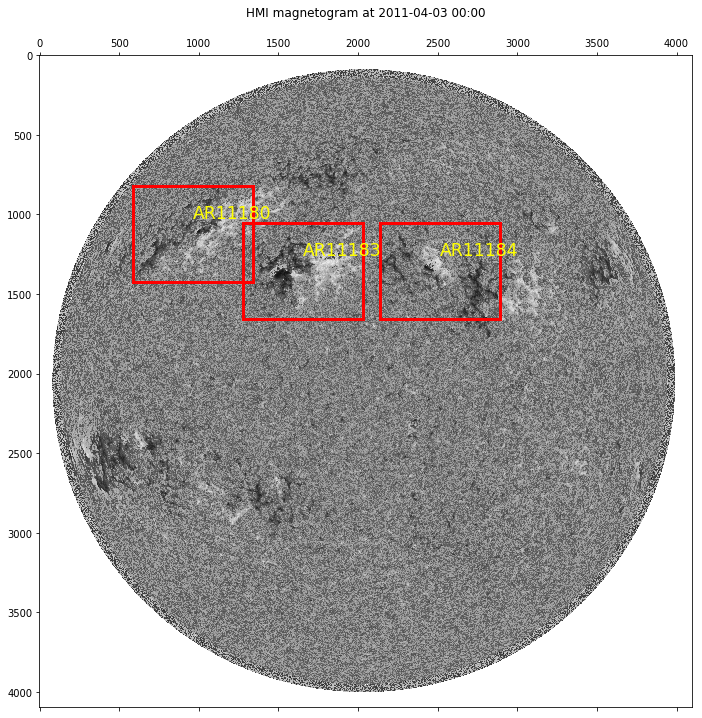

In [10]:
datestr = '2011-04-03'
moment = pd.to_datetime(datestr, format='%Y-%m-%d')
filepath=os.path.join(SAVE_PATH,'hmi.m_720s.' +  moment.strftime('%Y%m%d_%H%M%S_TAI.1.magnetogram.fits'))
mymap = read_fits_to_map(filepath, plot_show=False)
rc_list = region_coord_list(datestr, limit_deg=45)
draw_regions(mymap, rc_list)

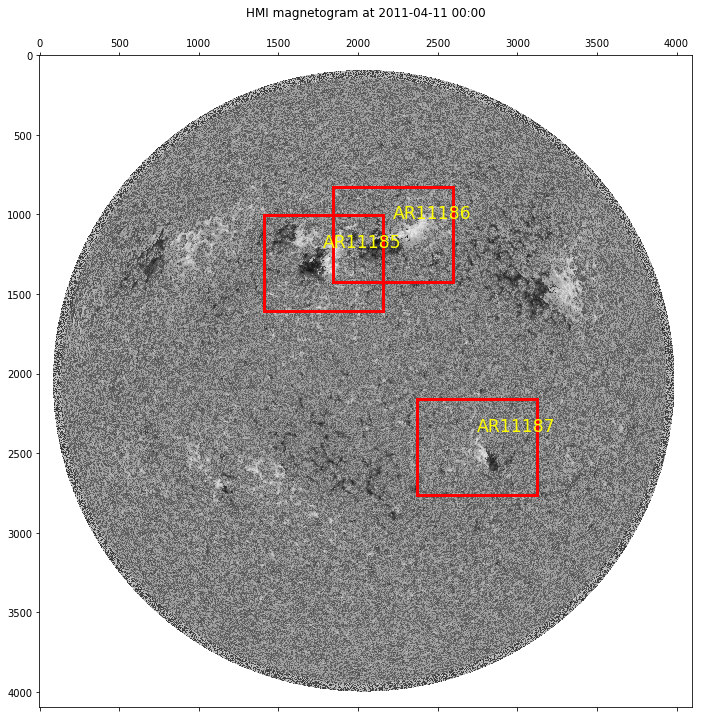

In [12]:
datestr = '2011-04-11'
moment = pd.to_datetime(datestr, format='%Y-%m-%d')
filepath=os.path.join(SAVE_PATH,'hmi.m_720s.' +  moment.strftime('%Y%m%d_%H%M%S_TAI.1.magnetogram.fits'))
mymap = read_fits_to_map(filepath, plot_show=False)
rc_list = region_coord_list(datestr, limit_deg=75)
draw_regions(mymap, rc_list)

In [1]:
datestr = '2011-04-08'
moment = pd.to_datetime(datestr, format='%Y-%m-%d')
filepath=os.path.join(SAVE_PATH,'hmi.m_720s.' +  moment.strftime('%Y%m%d_%H%M%S_TAI.1.magnetogram.fits'))
mymap = read_fits_to_map(filepath, plot_show=False)
rc_list = region_coord_list(datestr, limit_deg=75)
draw_regions(mymap, rc_list)

NameError: name 'os' is not defined

In [13]:
def date_compare(date):
    return date < datetime.datetime.fromtimestamp(time.mktime(time.strptime('2010-05-01', '%Y-%m-%d')))

